In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import tensorflow as tf
import cv2 as cv
import nibabel as nib
from tqdm import tqdm

# Link data


In [16]:
datalink = 'E:/Capstone_2/'
TRAIN = datalink + 'train/'
TEST = datalink + 'test/'

In [17]:
import os
files = os.listdir(datalink)

# Filter files with the ".csv" extension
csv_files = [file for file in files if file.endswith('.csv')]

# Print the list of CSV files
print(csv_files)

['annotations_test.csv', 'annotations_train.csv', 'image_labels_test.csv', 'image_labels_train.csv']


In [18]:
train_df = pd.read_csv(datalink + 'annotations_train.csv')
train_df.head()

,image_id,rad_ID,class_name,x_min,y_min,x_max,y_max,class_id,height,width
0,000295d6ff55184f19d99e95f93c3a55,R6,No finding,NaN,NaN,NaN,NaN,36,1486,1230
1,0008e7acbcdf2fedd05cc236e5594074_1,R2,Reticulonodular opacity,662.305730,369.480667,928.395922,762.425639,2,1338,1144
2,0008e7acbcdf2fedd05cc236e5594074_2,R2,Reticulonodular opacity,751.663843,742.127000,935.692066,1082.336509,2,1338,1144
3,0008e7acbcdf2fedd05cc236e5594074_3,R2,Reticulonodular opacity,601.565207,745.647614,859.927396,1137.128246,2,1338,1144
4,0008e7acbcdf2fedd05cc236e5594074_4,R2,Reticulonodular opacity,637.906722,695.705362,1010.454158,891.647267,2,1144,1338


In [19]:
dim = 256

In [20]:
train_df['image_path'] = [('E:/Capstone_2/train/' + train_df['image_id'][i] + '.jpg') for i in range(len(train_df))]
train_df.head()

,image_id,rad_ID,class_name,x_min,y_min,x_max,y_max,class_id,height,width,image_path
0,000295d6ff55184f19d99e95f93c3a55,R6,No finding,NaN,NaN,NaN,NaN,36,1486,1230,E:/Capstone_2/train/000295d6ff55184f19d99e95f9...
1,0008e7acbcdf2fedd05cc236e5594074_1,R2,Reticulonodular opacity,662.305730,369.480667,928.395922,762.425639,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...
2,0008e7acbcdf2fedd05cc236e5594074_2,R2,Reticulonodular opacity,751.663843,742.127000,935.692066,1082.336509,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...
3,0008e7acbcdf2fedd05cc236e5594074_3,R2,Reticulonodular opacity,601.565207,745.647614,859.927396,1137.128246,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...
4,0008e7acbcdf2fedd05cc236e5594074_4,R2,Reticulonodular opacity,637.906722,695.705362,1010.454158,891.647267,2,1144,1338,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...


# 36 classes

In [21]:
train_df = train_df[train_df.class_id!=37].reset_index(drop = True)
max(train_df["class_id"])

36

# Preprocessing

In [22]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']

train_df.head()

,image_id,rad_ID,class_name,x_min,y_min,x_max,y_max,class_id,height,width,image_path,x_mid,y_mid,w,h,area
0,000295d6ff55184f19d99e95f93c3a55,R6,No finding,NaN,NaN,NaN,NaN,36,1486,1230,E:/Capstone_2/train/000295d6ff55184f19d99e95f9...,NaN,NaN,NaN,NaN,NaN
1,0008e7acbcdf2fedd05cc236e5594074_1,R2,Reticulonodular opacity,0.578939,0.276144,0.811535,0.569825,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...,0.695237,0.422984,0.232596,0.293681,0.068309
2,0008e7acbcdf2fedd05cc236e5594074_2,R2,Reticulonodular opacity,0.657049,0.554654,0.817913,0.808921,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...,0.737481,0.681788,0.160864,0.254267,0.040902
3,0008e7acbcdf2fedd05cc236e5594074_3,R2,Reticulonodular opacity,0.525844,0.557285,0.751685,0.849872,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...,0.638764,0.703578,0.225841,0.292586,0.066078
4,0008e7acbcdf2fedd05cc236e5594074_4,R2,Reticulonodular opacity,0.476761,0.608134,0.755197,0.779412,2,1144,1338,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...,0.615979,0.693773,0.278436,0.171278,0.047690


In [23]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]
y = train_df['class_id']
X.shape, y.shape

((62628, 9), (62628,))

In [24]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Boot-shaped heart',
 'Peribronchovascular interstitial opacity',
 'Reticulonodular opacity',
 'Bronchial thickening',
 'Enlarged PA',
 'Cardiomegaly',
 'Other opacity',
 'Intrathoracic digestive structure',
 'Diffuse aveolar opacity',
 'Other lesion',
 'Consolidation',
 'Mediastinal shift',
 'Anterior mediastinal mass',
 'Other nodule/mass',
 'Dextro cardia',
 'Aortic enlargement',
 'Pleural effusion',
 'Stomach on the right side',
 'Atelectasis',
 'Calcification',
 'Interstitial lung disease - ILD',
 'Lung hyperinflation',
 'Egg on string sign',
 'Pulmonary fibrosis',
 'Infiltration',
 'Lung cavity',
 'Pneumothorax',
 'Edema',
 'Pleural thickening',
 'Clavicle fracture',
 'Chest wall mass',
 'Lung cyst',
 'Emphysema',
 'Bronchectasis',
 'Expanded edges of the anterior ribs',
 'Paraveterbral mass',
 'No finding']

# K-fold

In [25]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,rad_ID,class_name,x_min,y_min,x_max,y_max,class_id,height,width,image_path,x_mid,y_mid,w,h,area,fold
0,000295d6ff55184f19d99e95f93c3a55,R6,No finding,NaN,NaN,NaN,NaN,36,1486,1230,E:/Capstone_2/train/000295d6ff55184f19d99e95f9...,NaN,NaN,NaN,NaN,NaN,2
1,0008e7acbcdf2fedd05cc236e5594074_1,R2,Reticulonodular opacity,0.578939,0.276144,0.811535,0.569825,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...,0.695237,0.422984,0.232596,0.293681,0.068309,4
2,0008e7acbcdf2fedd05cc236e5594074_2,R2,Reticulonodular opacity,0.657049,0.554654,0.817913,0.808921,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...,0.737481,0.681788,0.160864,0.254267,0.040902,2
3,0008e7acbcdf2fedd05cc236e5594074_3,R2,Reticulonodular opacity,0.525844,0.557285,0.751685,0.849872,2,1338,1144,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...,0.638764,0.703578,0.225841,0.292586,0.066078,3
4,0008e7acbcdf2fedd05cc236e5594074_4,R2,Reticulonodular opacity,0.476761,0.608134,0.755197,0.779412,2,1144,1338,E:/Capstone_2/train/0008e7acbcdf2fedd05cc236e5...,0.615979,0.693773,0.278436,0.171278,0.047690,4


In [26]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
#print(val_files)

In [46]:
# import pandas as pd
# import os

# # Mapping of class names to class IDs
# class_mapping = {
#     "Boot-shaped heart": 0,
#     "Peribronchovascular interstitial opacity": 1,
#     "Reticulonodular opacity": 2,
#     "Bronchial thickening": 3,
#     "Enlarged PA": 4,
#     "Cardiomegaly": 5,
#     "Other opacity": 6,
#     "Intrathoracic digestive structure": 7,
#     "Diffuse aveolar opacity": 8,
#     "Other lesion": 9,
#     "Consolidation": 10,
#     "Mediastinal shift": 11,
#     "Anterior mediastinal mass": 12,
#     "Other nodule/mass": 13,
#     "Dextro cardia": 14,
#     "Aortic enlargement": 15,
#     "Pleural effusion": 16,
#     "Stomach on the right side": 17, 
#     "Atelectasis": 18,
#     "Calcification": 19,
#     "Interstitial lung disease - ILD": 20,
#     "Lung hyperinflation": 21,
#     "Egg on string sign": 22,
#     "Pulmonary fibrosis": 23,
#     "Infiltration": 24,
#     "Lung cavity": 25,
#     "Pneumothorax": 26,
#     "Edema": 27,
#     "Pleural thickening": 28,
#     "Clavicle fracture": 29,
#     "Chest wall mass": 30,
#     "Lung cyst": 31,
#     "Emphysema": 32,
#     "Bronchectasis": 33,
#     "Expanded edges of the anterior ribs": 34,
#     "Paraveterbral mass": 35,
#     "No finding": 36
# }

# # Function to normalize values between 0 and 1
# def normalize(value, min_val, max_val):
#     if pd.isnull(value):
#         return 0
#     return (value - min_val) / (max_val - min_val)

# # Read annotations CSV
# annotations_df = pd.read_csv(datalink+'annotations_train.csv')

# # Read image labels CSV
# image_labels_df = pd.read_csv(datalink+'image_labels_train.csv')

# # Merge annotations and image labels dataframes
# merged_df = pd.merge(annotations_df, image_labels_df, on=['image_id', 'rad_ID'])

# # Create labels folder if not exists
# if not os.path.exists('labels38'):
#     os.makedirs('labels38')

# # Iterate over rows to generate YOLOv5 format labels
# for _, row in merged_df.iterrows():
#     class_id = class_mapping[row['class_name']]
#     image_width = row['width']
#     image_height = row['height']

#     if class_id == 36:  # No finding
#         # Create an empty label file
#         label_file_path = os.path.join('labels38', f"{row['image_id']}.txt")
#         open(label_file_path, 'a').close()  # Creates an empty file
#         continue

#     x_center = ((row['x_min'] + row['x_max']) / 2) / image_width
#     y_center = ((row['y_min'] + row['y_max']) / 2) / image_height
#     width_a = (row['x_max'] - row['x_min']) / image_width  # Parentheses added for correct order of operations
#     height_a = (row['y_max'] - row['y_min']) / image_height  # Parentheses added for correct order of operations

#     label_str = f"{class_id} {x_center} {y_center} {width_a} {height_a}"

#     # Save label to file
#     label_file_path = os.path.join('labels38', f"{row['image_id']}.txt")
#     with open(label_file_path, 'a') as f:
#         f.write(label_str + '\n')


In [14]:
# import pandas as pd
# import os

# # Mapping of class names to class IDs
# class_mapping = {
#     "Boot-shaped heart": 0,
#     "Peribronchovascular interstitial opacity": 1,
#     "Reticulonodular opacity": 2,
#     "Bronchial thickening": 3,
#     "Enlarged PA": 4,
#     "Cardiomegaly": 5,
#     "Other opacity": 6,
#     "Intrathoracic digestive structure": 7,
#     "Diffuse aveolar opacity": 8,
#     "Other lesion": 9,
#     "Consolidation": 10,
#     "Mediastinal shift": 11,
#     "Anterior mediastinal mass": 12,
#     "Other nodule/mass": 13,
#     "Dextro cardia": 14,
#     "Aortic enlargement": 15,
#     "Pleural effusion": 16,
#     "Stomach on the right side": 17, 
#     "Atelectasis": 18,
#     "Calcification": 19,
#     "Interstitial lung disease - ILD": 20,
#     "Lung hyperinflation": 21,
#     "Egg on string sign": 22,
#     "Pulmonary fibrosis": 23,
#     "Infiltration": 24,
#     "Lung cavity": 25,
#     "Pneumothorax": 26,
#     "Edema": 27,
#     "Pleural thickening": 28,
#     "Clavicle fracture": 29,
#     "Chest wall mass": 30,
#     "Lung cyst": 31,
#     "Emphysema": 32,
#     "Bronchectasis": 33,
#     "Expanded edges of the anterior ribs": 34,
#     "Paraveterbral mass": 35,
#     "No finding": 36
# }

# # Read annotations CSV
# annotations_df = pd.read_csv(datalink+'annotations_train.csv')

# # Create labels folder if not exists
# if not os.path.exists('labels38'):
#     os.makedirs('labels38')

# # Iterate over rows to generate YOLOv5 format labels
# for _, row in annotations_df.iterrows():
#     class_id = class_mapping[row['class_name']]
#     image_width = row['width']
#     image_height = row['height']

#     if class_id == 36:  # No finding
#         # Create an empty label file
#         label_file_path = os.path.join('labels38', f"{row['image_id']}.txt")
#         open(label_file_path, 'a').close()  # Creates an empty file
#         continue

#     x_center = ((row['x_min'] + row['x_max']) / 2) / image_width
#     y_center = ((row['y_min'] + row['y_max']) / 2) / image_height
#     width_a = (row['x_max'] - row['x_min']) / image_width  # Parentheses added for correct order of operations
#     height_a = (row['y_max'] - row['y_min']) / image_height  # Parentheses added for correct order of operations

#     label_str = f"{class_id} {x_center} {y_center} {width_a} {height_a}"

#     # Save label to file
#     label_file_path = os.path.join('labels38', f"{row['image_id']}.txt")
#     with open(label_file_path, 'a') as f:
#         f.write(label_str + '\n')


In [14]:
# os.makedirs('E:/Capstone/data/yolo/labels/train', exist_ok = True)
# os.makedirs('E:/Capstone/data/yolo/labels/val', exist_ok = True)
# os.makedirs('E:/Capstone/data/yolo/images/train', exist_ok = True)
# os.makedirs('E:/Capstone/data/yolo/images/val', exist_ok = True)
# label_dir = 'E:/Capstone/labels/train/'
# for file in tqdm(train_files):
#     shutil.copy(file, 'E:/Capstone/data/yolo/images/train/')
#     filename = file.split('/')[-1].split('.')[0]
#     shutil.copy(os.path.join(label_dir, filename+'.txt'), 'E:/Capstone/data/yolo/labels/train/')
    
# #TODO: Change test folder to val      
# for file in tqdm(val_files):
#     shutil.copy(file, 'E:/Capstone/data/yolo/images/val/')
#     filename = file.split('/')[-1].split('.')[0]
#     shutil.copy(os.path.join(label_dir, filename+'.txt'), 'E:/Capstone/data/yolo/labels/val')

In [27]:
import os
import shutil
from tqdm import tqdm

os.makedirs('E:/Capstone_2/yolo/labels/train', exist_ok=True)
os.makedirs('E:/Capstone_2/yolo/labels/val', exist_ok=True)
os.makedirs('E:/Capstone_2/yolo/images/train', exist_ok=True)
os.makedirs('E:/Capstone_2/yolo/images/val', exist_ok=True)
label_dir = 'E:/Capstone_2/labels38/'

for file in tqdm(train_files):
    shutil.copy(file, 'E:/Capstone_2/yolo/images/train/')
    filename = file.split('/')[-1].split('.')[0]
    try:
        shutil.copy(os.path.join(label_dir, filename+'.txt'), 'E:/Capstone_2/yolo/labels/train/')
    except FileNotFoundError:
        continue
    
# Change test folder to val
for file in tqdm(val_files):
    shutil.copy(file, 'E:/Capstone_2/yolo/images/val/')
    filename = file.split('/')[-1].split('.')[0]
    try:
        shutil.copy(os.path.join(label_dir, filename+'.txt'), 'E:/Capstone_2/yolo/labels/val/')
    except FileNotFoundError:
        continue

100%|██████████████████████████████████████████████████████████████████████████████| 6713/6713 [02:48<00:00, 39.83it/s]


# Get class name

In [28]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Boot-shaped heart',
 'Peribronchovascular interstitial opacity',
 'Reticulonodular opacity',
 'Bronchial thickening',
 'Enlarged PA',
 'Cardiomegaly',
 'Other opacity',
 'Intrathoracic digestive structure',
 'Diffuse aveolar opacity',
 'Other lesion',
 'Consolidation',
 'Mediastinal shift',
 'Anterior mediastinal mass',
 'Other nodule/mass',
 'Dextro cardia',
 'Aortic enlargement',
 'Pleural effusion',
 'Stomach on the right side',
 'Atelectasis',
 'Calcification',
 'Interstitial lung disease - ILD',
 'Lung hyperinflation',
 'Egg on string sign',
 'Pulmonary fibrosis',
 'Infiltration',
 'Lung cavity',
 'Pneumothorax',
 'Edema',
 'Pleural thickening',
 'Clavicle fracture',
 'Chest wall mass',
 'Lung cyst',
 'Emphysema',
 'Bronchectasis',
 'Expanded edges of the anterior ribs',
 'Paraveterbral mass',
 'No finding']

# YOLOv5

In [29]:
# !git clone https://github.com/ultralytics/yolov5  
%cd yolov5

[WinError 2] The system cannot find the file specified: 'yolov5'
E:\Capstone_2\yolov5


In [30]:
# !pip install -r requirements.txt # install dependencies
import torch
from IPython.display import Image, clear_output  # to display images
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.2.0+cpu CPU


## Train

In [43]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = 'E:/Capstone/data/yolo/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('E:/Capstone/data/yolo/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('E:/Capstone/data/yolo/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 37,
    names = classes
    )

with open(join( cwd , 'yolov5.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'yolov5.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Boot-shaped heart
- Peribronchovascular interstitial opacity
- Reticulonodular opacity
- Bronchial thickening
- Enlarged PA
- Cardiomegaly
- Other opacity
- No finding
- Diffuse aveolar opacity
- Other lesion
- Consolidation
- Mediastinal shift
- Anterior mediastinal mass
- Other nodule/mass
- Dextro cardia
- Aortic enlargement
- Pleural effusion
- Stomach on the right side
- Atelectasis
- Calcification
- Interstitial lung disease - ILD
- Lung hyperinflation
- Egg on string sign
- Pulmonary fibrosis
- Infiltration
- Lung cavity
- Pneumothorax
- Edema
- Pleural thickening
- Clavicle fracture
- Chest wall mass
- Lung cyst
- Emphysema
- Bronchectasis
- Intrathoracic digestive structure
- Expanded edges of the anterior ribs
- Paraveterbral mass
nc: 37
train: E:/Capstone/data/yolo/train.txt
val: E:/Capstone/data/yolo/val.txt



from yolov5 import utils
display = utils.notebook_init()  # checks

In [48]:
!python train.py --img 256 --batch 4 --epochs 1 --data E:/Capstone/data/yolo/yolov5.yaml --weights yolov5x.pt --cache


train: weights=yolov5x.pt, cfg=, data=E:/Capstone/data/yolo/yolov5.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=1, batch_size=4, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github:  YOLOv5 is out of date by 2 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-295-gac6c4383 Python-3.11.5 torch-2.2.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, war

# output

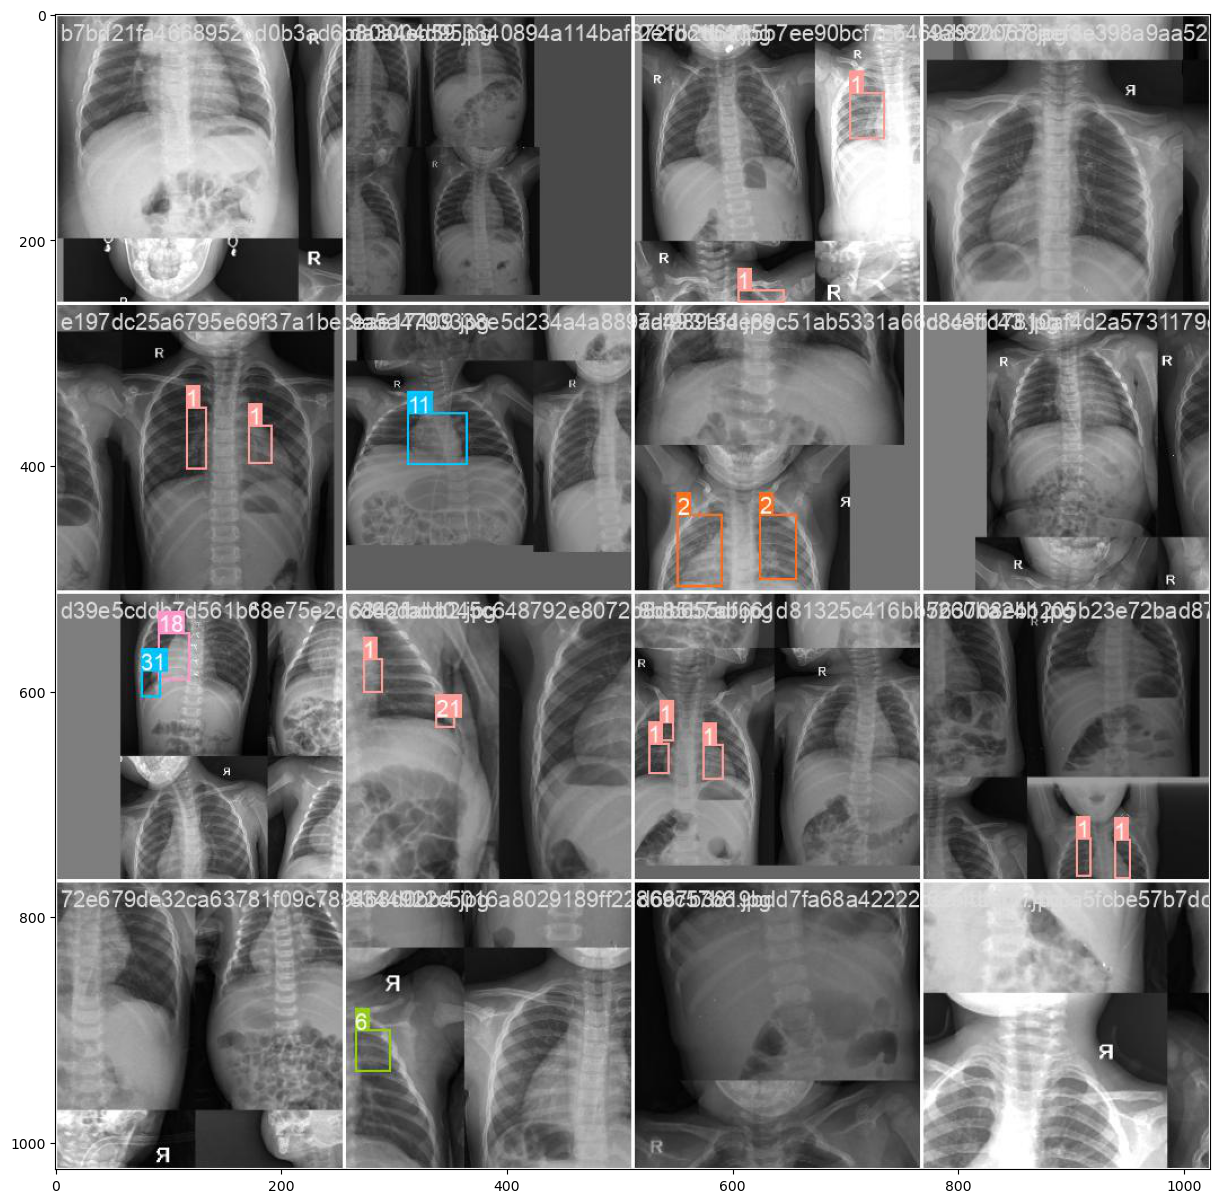

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp6/train_batch0.jpg'))
plt.savefig('fig1.png')
# plt.figure(figsize = (15, 15))
# plt.imshow(plt.imread('runs/train/exp2/train_batch1.jpg'))

# plt.figure(figsize = (15, 15))
# plt.imshow(plt.imread('runs/train/exp2/train_batch2.jpg'))

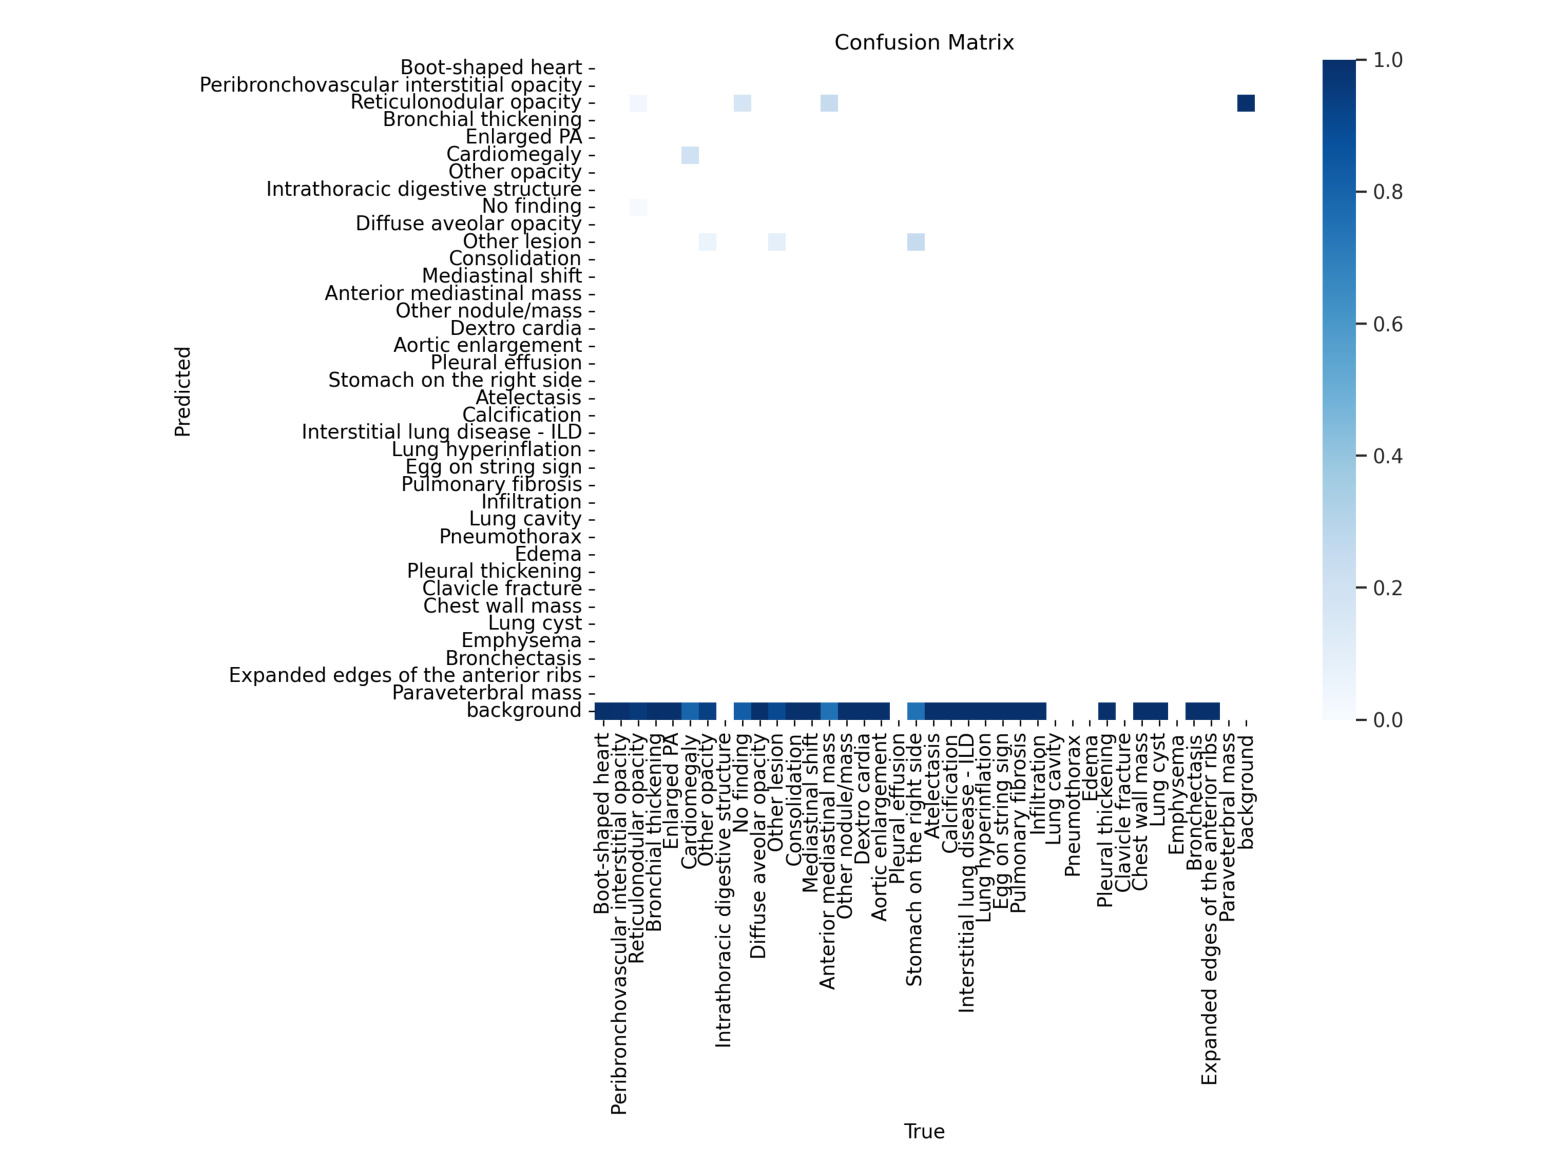

In [19]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp6/confusion_matrix.png'));

# Inference


In [21]:
!python detect.py --weights runs/train/exp6/weights/best.pt --imgsz 256 \
--conf 0.15 \
--iou 0.5 \
--source 'E:/Capstone/data/yolo/images/val/' \
--exist-ok

detect: weights=['runs/train/exp6/weights/best.pt'], source='E:/Capstone/data/yolo/images/val/', data=data\coco128.yaml, imgsz=[256, 256], conf_thres=0.15, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-295-gac6c4383 Python-3.11.5 torch-2.2.0+cpu CPU

Traceback (most recent call last):
  File "E:\Capstone\yolov5\detect.py", line 312, in <module>
    main(opt)
  File "E:\Capstone\yolov5\detect.py", line 307, in main
    run(**vars(opt))
  File "D:\anaconda\Lib\site-packages\torch\utils\_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "E:\Capstone\yolov5\detect.py", line 115, in run
    model = DetectMultiBa

## Test

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/test.csv')
test_df.head()

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376


In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt \
--img 256 \
--conf 0.01 \
--iou 0.4 \
--source '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/test/' \
--save-txt --save-conf --exist-ok

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/test/, imgsz=[256, 256], conf_thres=0.01, iou_thres=0.4, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-108-g53349da torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 444 layers, 86260891 parameters, 0 gradients, 204.2 GFLOPs
image 1/3000 /content/drive/.shortcut-targets-by-id/1ScH0hjsInJJUGEX-k7MCjf15l7Kq0qcS/CXR-Abnormalities-Detection/data/test/002a34c58c5b758217ed1f584ccbcfe9.png: 256x256 1 Aortic enlargement, 1 Cardiomegaly, 1 ILD, 6 Pleural thickenings, Done. (0.064s)
image 2/3000 /content/drive/.shortcut-targets-by-id/1ScH0hjsInJJUGEX-k7MCjf15l7

In [ ]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [ ]:
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

  0%|          | 0/2997 [00:00<?, ?it/s]

In [ ]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv('submission.csv',index = False)
sub_df.tail()

,image_id,PredictionString
2995,7f5503caa936a623b4388fbd88e890c5,5 0.0 351 607 1104 1932 9 0.0 1600 1783 2312 2...
2996,c97e54a78bab9c05ce2e04fe6c284bcd,11 0.0 1980 588 2316 744 11 0.0 1032 588 1500 ...
2997,33218cf183c1224a74ccfb514e827e15,11 0.0 1798 587 1980 798 7 0.0 1643 499 1770 6...
2998,04b700c4815f088728db9f093c739707,11 0.0 1776 574 2018 766 11 0.0 1494 551 1727 ...
2999,14da9051525bd2504dd56938f92644ef,3 0.0 756 1405 1519 1680 11 0.0 1277 513 1472 ...


In [ ]:
# !zip -r /content/yolov5-2.zip /content/yolov5

# from google.colab import files
# files.download("/content/yolov5.zip")

updating: content/yolov5/ (stored 0%)
updating: content/yolov5/export.py (deflated 72%)
updating: content/yolov5/detect.py (deflated 67%)
updating: content/yolov5/Dockerfile (deflated 55%)
updating: content/yolov5/.pre-commit-config.yaml (deflated 61%)
updating: content/yolov5/.gitignore (deflated 55%)
updating: content/yolov5/__pycache__/ (stored 0%)
updating: content/yolov5/__pycache__/val.cpython-37.pyc (deflated 41%)
updating: content/yolov5/LICENSE (deflated 66%)
updating: content/yolov5/README.md (deflated 71%)
updating: content/yolov5/yolov5x.pt (deflated 8%)
updating: content/yolov5/.gitattributes (deflated 4%)
updating: content/yolov5/models/ (stored 0%)
updating: content/yolov5/models/__init__.py (stored 0%)
updating: content/yolov5/models/yolov5s.yaml (deflated 60%)
updating: content/yolov5/models/common.py (deflated 71%)
updating: content/yolov5/models/tf.py (deflated 70%)
updating: content/yolov5/models/yolov5l.yaml (deflated 61%)
updating: content/yolov5/models/__pycache_

FileNotFoundError: ignored